# Условие задачи
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Предстоит построить прототип модели машинного обучения

Целевой признак: столбец `'EndDate'` равен `'No'`.

Основная метрика: AUC-ROC.
Дополнительная метрика: Accuracy.

### Этапы разработки

1.Составьте план работы. Исходное условие задачи заведомо неполное и содержит лишнюю информацию. Проведите исследовательский анализ данных, чтобы понять, какие вопросы подготовить. В конце Jupyter Notebook напишите:
          
      1.1 Список уточняющих вопросов.
      1.2 Примерный план решения задачи. Пропишите 3–5 основных шагов, каждый поясните не более 2 предложениями.
         

2.Уточните задачу. Задайте вопросы тимлиду.

3.Разработайте модель. Отдайте код на проверку ревьюверу.

4.Подготовьте отчёт. Отправьте отчёт тимлиду, чтобы он проверил успешность выполнения задания.

In [1]:
#pip install plot-metric

<a name="1common."></a>
## <a name="0.0"></a>Содержание:
* [Шаг 1. Загрузим данные и подготовимся к их анализу](#1.)
* [Шаг 2. Кодирование и масштабирование признаков](#2.)
* [Шаг 3. Разбиение данных на выборки](#3.)
    
* [Шаг 4. Исследование моделей](#4.)     
     
* [Шаг 5. Результаты метрик моделей в одой таблице](#5.)
* [Шаг 6. Проверка наилучших моделей на тесте. ROC-AUC график. Матрица ошибок](#6.)
* [Шаг 7. Наиболее значимые признаки](#7.)
* [Шаг 8. Кластеризация клиентов](#8.)
* [Шаг 9. Общий вывод](#9.)

<a name="1."></a><br/>
<font size="5"><b>1. Загрузим данные и подготовимся к их анализу</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [2]:
#pip install Keras

In [3]:
#pip install tensorflow

In [4]:
import pandas as pd
from functools import reduce
import datetime
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

import pandas as pd

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense
from tensorflow.keras.optimizers import Adam

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score,  GridSearchCV 
from sklearn.model_selection import cross_val_predict

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler

from plot_metric.functions import BinaryClassification

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [5]:
# снимем ограничение на кол-во и ширину столбцов
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [6]:
data_contract=pd.read_csv('datasets/final_provider/contract.csv')
data_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [7]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
data_internet=pd.read_csv(('datasets/final_provider/internet.csv'))
data_internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [9]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
data_personal=pd.read_csv('datasets/final_provider/personal.csv')
data_personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [11]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [12]:
data_phone=pd.read_csv('datasets/final_provider/phone.csv')
data_phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [13]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [14]:
#объединим все таблицы в одну
data_frames = [data_contract,data_internet,data_personal,data_phone]

In [15]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['customerID'],
                                            how='outer'), data_frames)#.fillna('void')


In [16]:
df_merged.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [17]:
#общая информация о таблице
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [18]:
#изменим тип данных столбца BeginDate, TotalCharges
df_merged['BeginDate'] = pd.to_datetime(df_merged['BeginDate'])
df_merged['TotalCharges'] = pd.to_numeric(df_merged['TotalCharges'], errors='coerce')

In [19]:
#убедимся, что тип изменился
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

In [20]:
#проверим на наличие дубликатов
df_merged.duplicated().sum()

0

In [21]:
#посмотрим на количество пропусков
df_merged.isna().sum()

customerID          0   
BeginDate           0   
EndDate             0   
Type                0   
PaperlessBilling    0   
PaymentMethod       0   
MonthlyCharges      0   
TotalCharges        11  
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender              0   
SeniorCitizen       0   
Partner             0   
Dependents          0   
MultipleLines       682 
dtype: int64

In [22]:
#посмотрим на долю пропусков в связи с объединением таблиц
df_merged['InternetService'].isna().sum()/len(df_merged['InternetService'])

0.21666903308249325

In [23]:
#посмотрим на долю пропусков в связи с объединением таблиц
df_merged['MultipleLines'].isna().sum()/len(df_merged['MultipleLines'])

0.09683373562402385

In [24]:
df_merged['EndDate_year'] = df_merged['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x) 
df_merged['EndDate_year'].head(5)

0    2020-02-01         
1    2020-02-01         
2    2019-12-01 00:00:00
3    2020-02-01         
4    2019-11-01 00:00:00
Name: EndDate_year, dtype: object

In [25]:
df_merged['EndDate_year'] = pd.to_datetime(df_merged['EndDate_year'])
df_merged['EndDate_year'] = df_merged['EndDate_year'].dt.year
df_merged['EndDate_year'].head(3)

0    2020
1    2020
2    2019
Name: EndDate_year, dtype: int64

In [26]:
#превратим целевой столбец в бинарный, где 0 - соответствует "NO", 1 - "YES"(дата расторжения договора, клиент ушел)
df_merged['EndDate'] = df_merged['EndDate'].apply(lambda x: '0' if x == 'No' else '1').astype(int)    

In [27]:
#посмотрим на баланс классов 
df_merged['EndDate'].value_counts()

0    5174
1    1869
Name: EndDate, dtype: int64

In [28]:
#долевое отношение классов
df_merged['EndDate'].where(df_merged['EndDate'] == 0).count()/len(df_merged['EndDate'])

0.7346301292063041

In [29]:
df_merged['EndDate'].where(df_merged['EndDate'] == 1).count()/len(df_merged['EndDate'])

0.2653698707936959

In [30]:
#разделим столбец BeginDate год
df_merged['Begin_year'] = df_merged['BeginDate'].dt.year

In [31]:
df_merged['Live_period'] = df_merged['EndDate_year'] - df_merged['Begin_year']
df_merged['Live_period'].head(10)

0    0
1    3
2    0
3    4
4    0
5    0
6    2
7    1
8    2
9    6
Name: Live_period, dtype: int64

In [32]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   int64         
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

In [33]:
#проверим, что столбцы добавились
df_merged.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines', 'EndDate_year', 'Begin_year',
       'Live_period'],
      dtype='object')

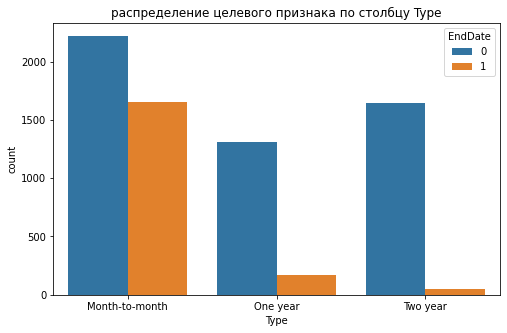

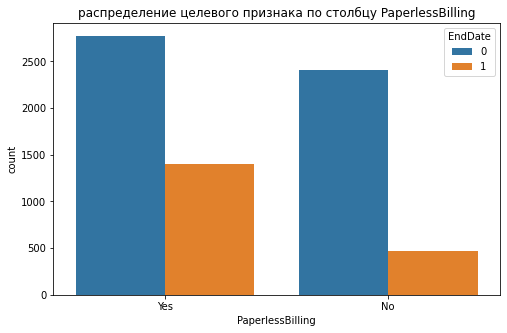

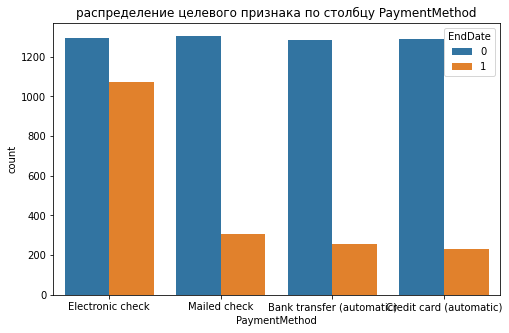

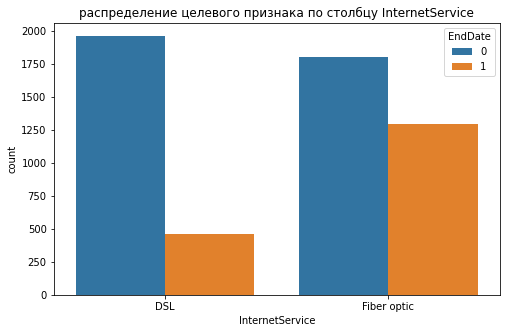

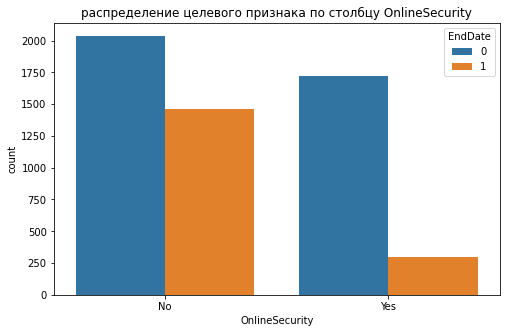

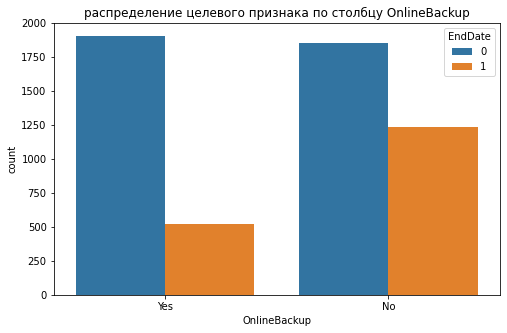

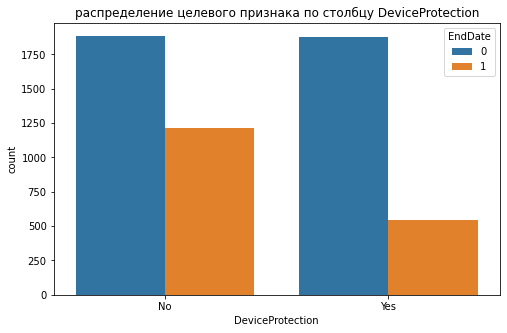

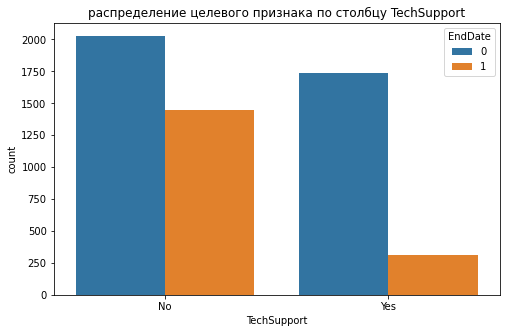

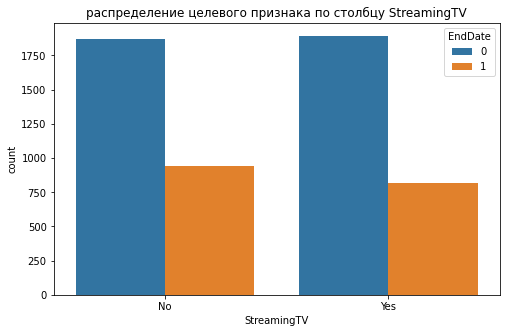

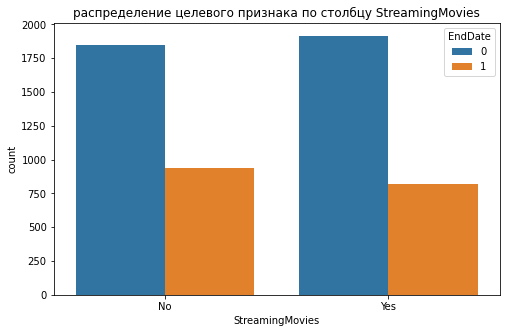

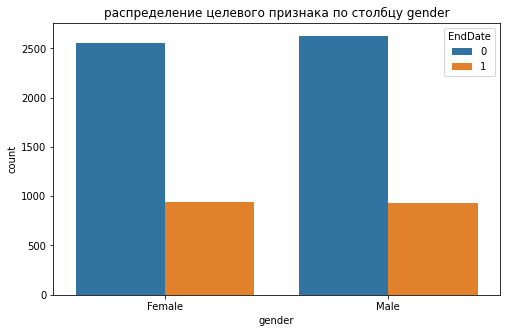

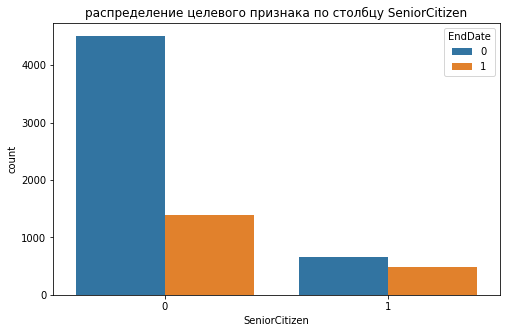

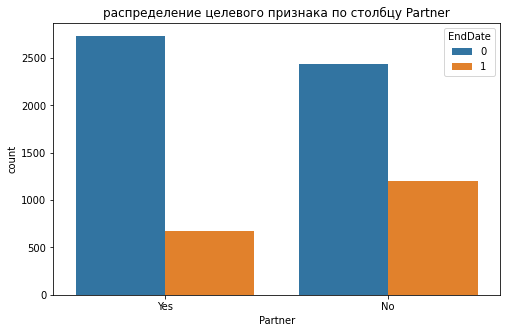

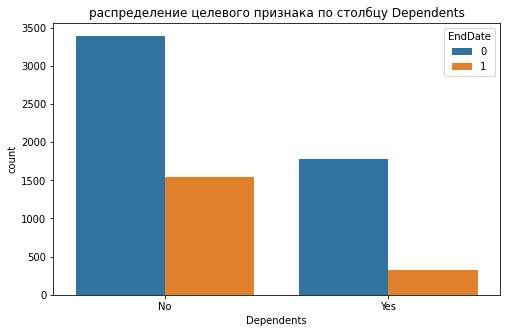

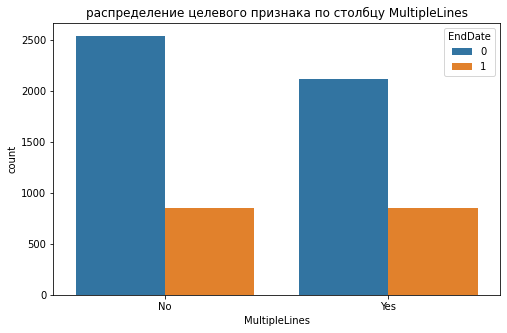

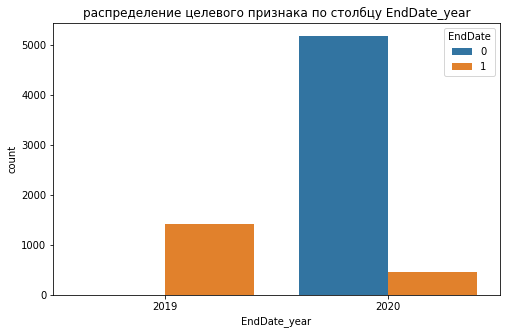

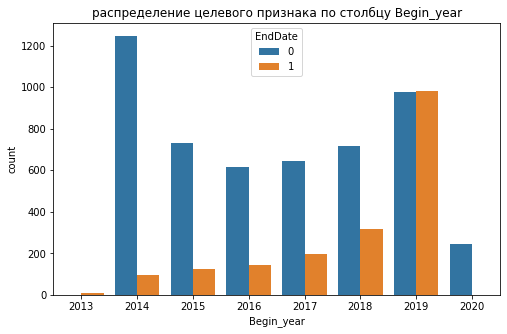

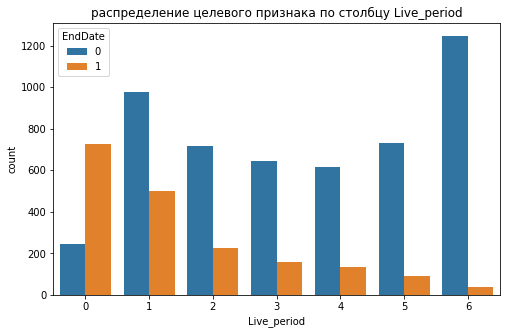

In [34]:
#распределение целевого признака по столбцам
for column in df_merged.drop(columns = ['customerID','BeginDate','EndDate','MonthlyCharges', 'TotalCharges']).columns:
    fig, ax = plt.subplots(figsize=(8,5))
    sns.countplot(x=column, hue='EndDate', data=df_merged, ax=ax)
    plt.title('распределение целевого признака по столбцу '+ str(column))
    plt.show();

<Figure size 800x640 with 0 Axes>

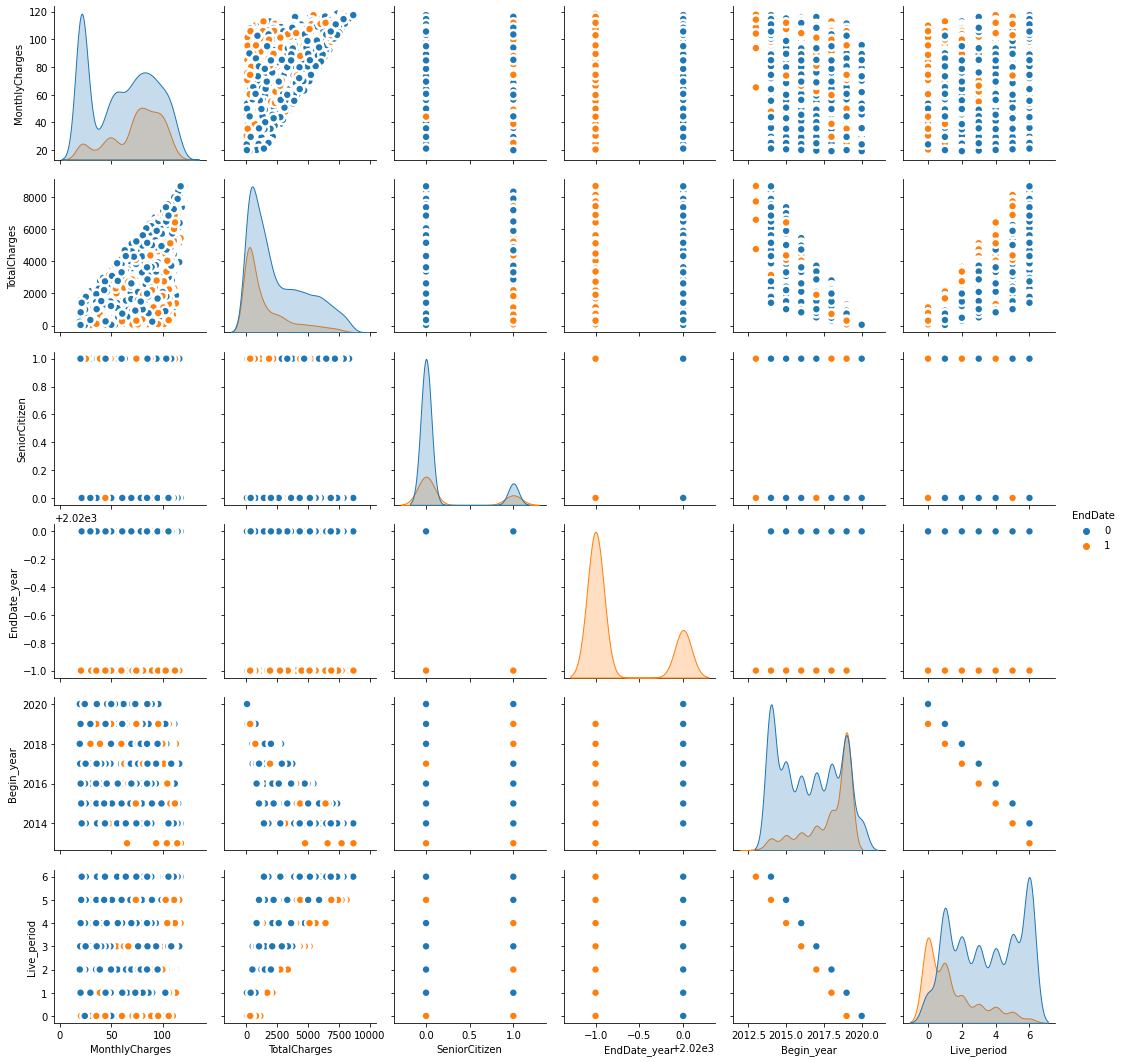

In [35]:
#взаимосвязь между всеми возможными парами числовых переменных
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(df_merged, kind='scatter', hue='EndDate', plot_kws=dict(s=80, edgecolor='white', linewidth=2.5))
#plt.title('взаимосвязь между всеми возможными парами числовых переменных')
plt.show();

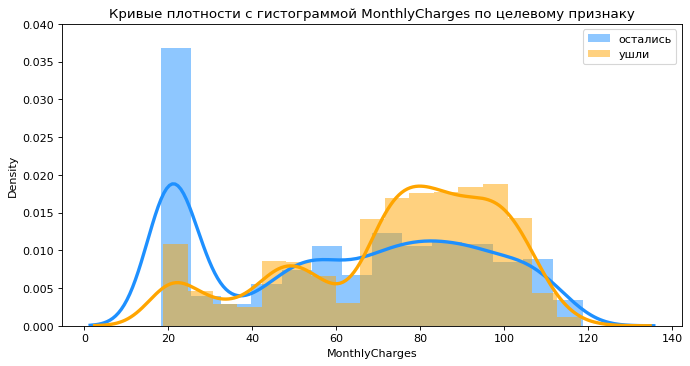

In [36]:
plt.figure(figsize=(10,5), dpi= 80)
sns.distplot(df_merged.loc[df_merged['EndDate'] == 0, 'MonthlyCharges'], 
             color='dodgerblue', label='остались', hist_kws={'alpha':.5}, kde_kws={'linewidth':3})
sns.distplot(df_merged.loc[df_merged['EndDate'] == 1, 'MonthlyCharges'], 
             color='orange', label='ушли', hist_kws={'alpha':.5}, kde_kws={'linewidth':3})
plt.ylim(0, 0.04)

plt.title('Кривые плотности с гистограммой MonthlyCharges по целевому признаку', fontsize=12)
plt.legend()
plt.show()

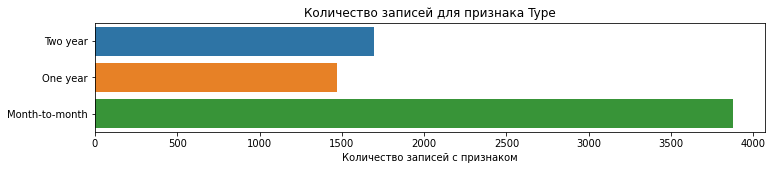

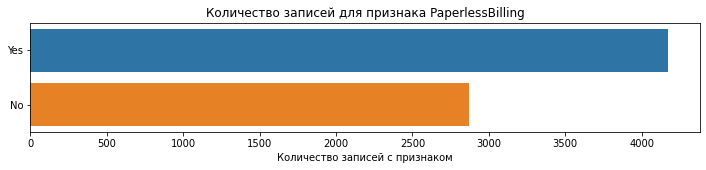

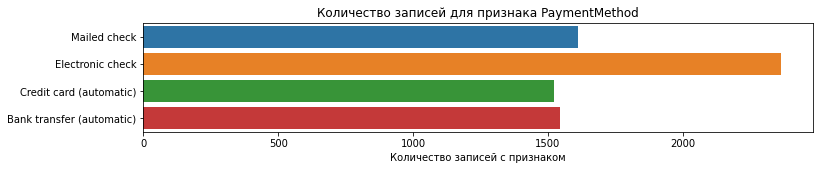

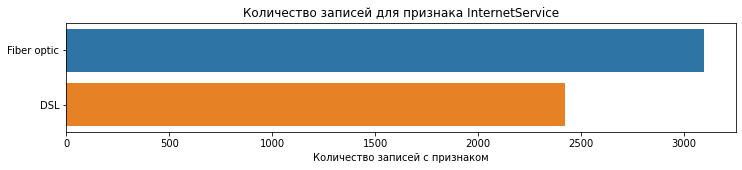

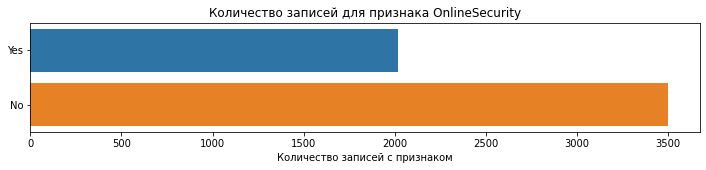

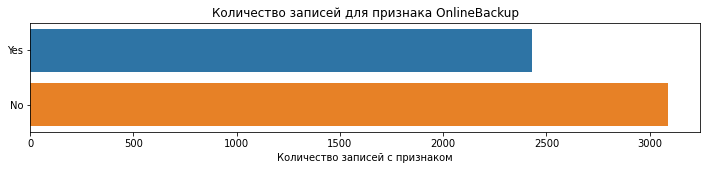

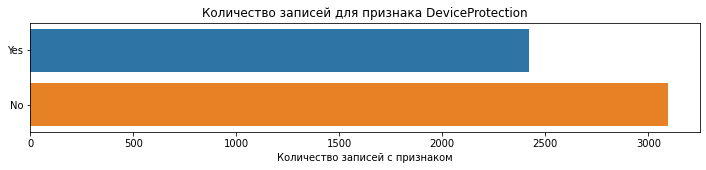

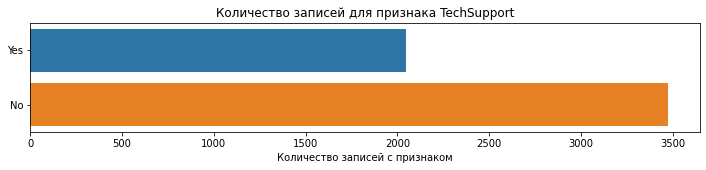

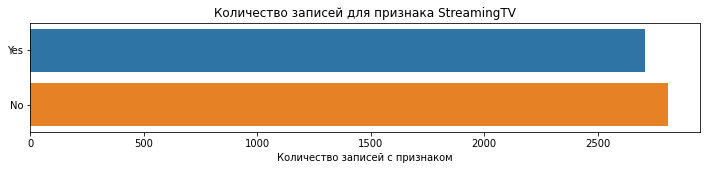

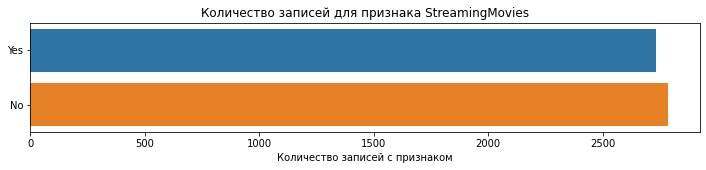

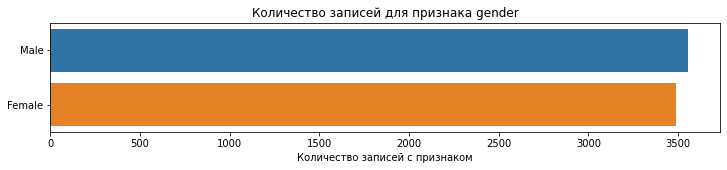

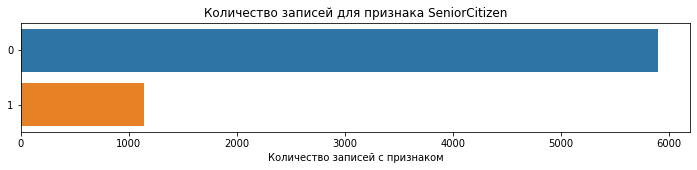

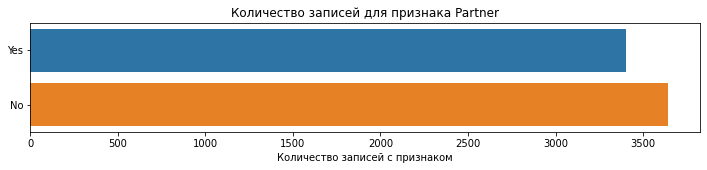

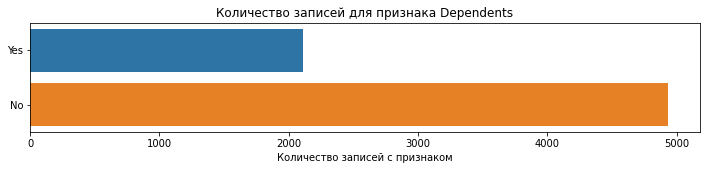

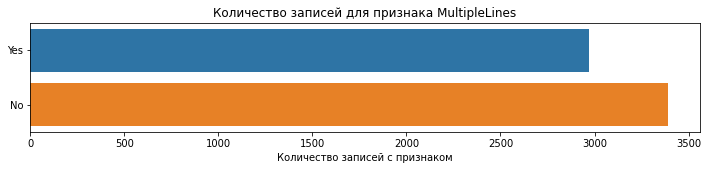

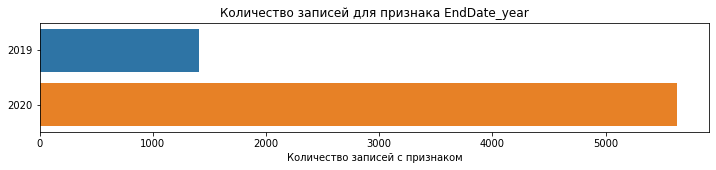

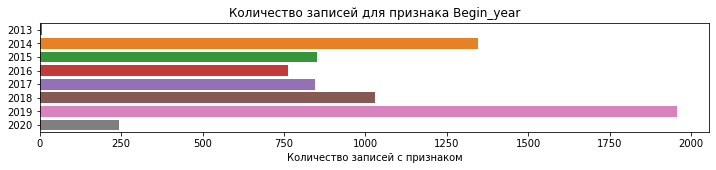

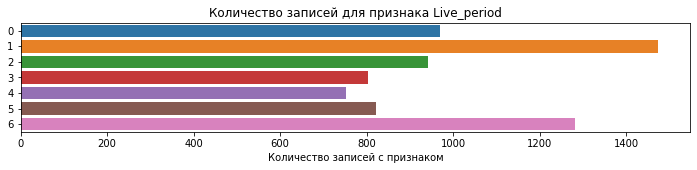

In [37]:
# общеe распределениe данных
for column in df_merged.drop(columns = ['customerID','BeginDate','EndDate','MonthlyCharges', 'TotalCharges']).columns:
    fig, ax = plt.subplots(figsize=(12,2))
    sns.countplot(y=column, data=df_merged.sort_values(by=column, ascending=False), ax=ax, saturation=0.8, orient ='h')
    plt.title('Количество записей для признака '+ str(column))
    plt.xlabel('Количество записей с признаком')
    plt.ylabel('')
    plt.show();

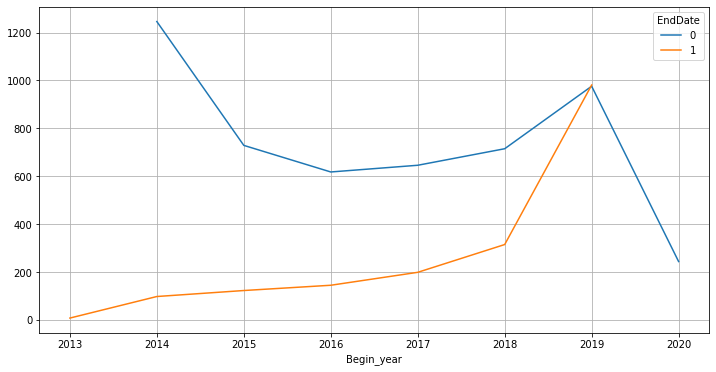

In [38]:
#Убедимся, что действительно есть отток клиентов
type_pivot=df_merged.pivot_table(index='Begin_year', columns='EndDate', values = 'MonthlyCharges', aggfunc='count')
type_pivot.plot(figsize=(12,6), grid=True);

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Вывод:  </b> Загрузили данные. Объединили 4 таблицы в одну. В итоге получилось 7043 строки и 23. В объединенной таблице появились пропуски. их удалять не будем.(доля пропусков 20% и 9%). При необходимости, заполню их словом void(русс. "пустота"). Изменила тип данных столбцов на наиболее подходящие. Поскольку , наша задача остановить отток клиентов, и целевым признаком является столбец 'EndDate' == 'No', то логично предположить, что дата разрыва контракта в этом столбце не важна и ее можно заменить на 'YES'. Таким образом получили задачу бинарной классификации.



Выяснили, что классы не сбалансированы. 74% - класс "0"(действующий контракт) и 26% - класс "1"(контракт расторгнут). Посмотрели на распределение целевого признака по столбцам. Из графиков видно, что клиенты, которые остались, в целом не имеют явно выраженных предпочтений в собираемых данных. Например: практически одинаковое количество действующих клиентов имеют подписку на TV и не имеют. Что же касается, класса "1" - там четко видны предпочтения. Также можно сделать вывод, что большенство контрактов расторгается к концу года.



Также можно сказать, что основная действующих клиентов платить min месячную оплату. Те, что ушли платили больше среднего. Для некоторых столбцов данные "ушли"/"остались" распределены практически одинаково.



Последний график подтверждает опасения компании. Действительно, заключение новых договоров пошло на спад, а количество расторжения - увеличивается. </div>



## Примерный план решения задачи:

1. выделить целевой признак
2. разбить данные на train, valid и test(если решу воспользоваться кросс-валидацией, то только на train и test)
3. провести кодирование признаков с помощью OHE
4. сделать масштабирование некоторых столбцов
5. обучить модели бинарной классификации: DecisionTreeClassifier, RandomForestClassifier, LogisticRegression,  GradientBoostingClassifie, CatBoostClassifier
6. вычислить метрики accuracy и roc_auc_score
7. построить графики ROC-AUC
8. проверить на тестовой выборке модель с наилучшими подобранными ранее гиперпараметрами
9. возможно, сделаю кластеризацию пользователей

<a name="2."></a><br/>
<font size="5"><b>2. Кодирование и масштабирование признаков.</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [39]:
df_merged.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,EndDate_year,Begin_year,Live_period
0,7590-VHVEG,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN,2020,2020,0
1,5575-GNVDE,2017-04-01,0,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,2020,2017,3
2,3668-QPYBK,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,2019,2019,0


In [40]:
#удалим не нужные столбцы
df_merged=df_merged.drop(['customerID','BeginDate', 'EndDate_year','Begin_year'], axis=1)

In [41]:
df_merged

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Live_period
0,0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN,0
1,0,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,3
2,1,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,0
3,0,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN,4
4,1,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,2
7039,0,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes,6
7040,0,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,Female,0,Yes,Yes,NaN,1
7041,1,Month-to-month,Yes,Mailed check,74.40,306.60,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,Yes,0


In [42]:
df_merged.columns

Index(['EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines', 'Live_period'],
      dtype='object')

In [43]:
#проведем ohe-кодирование котегориальных столбцов
df_merged_categ=df_merged.drop(['MonthlyCharges', 'TotalCharges', 'Live_period'], axis=1)

df_ohe = pd.get_dummies(df_merged_categ, drop_first=True)
#df_ohe.info()

In [44]:
#объединим таблицы категориальных признаков и численных.
df=df_merged[['MonthlyCharges', 'TotalCharges', 'Live_period']].join(df_ohe, how='right')
df.dropna(inplace=True)
#df.info()
#df.isnull().sum()

In [45]:
df

,MonthlyCharges,TotalCharges,Live_period,EndDate,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes
0,29.85,29.85,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0
1,56.95,1889.50,3,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
2,53.85,108.15,0,1,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0
3,42.30,1840.75,4,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0
4,70.70,151.65,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,84.80,1990.50,2,0,0,1,0,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1
7039,103.20,7362.90,6,0,0,1,0,1,1,0,0,1,0,1,1,0,1,1,0,1,1,1
7040,29.60,346.45,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0
7041,74.40,306.60,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,1


<a name="3."></a><br/>
<font size="5"><b>3. Разбиение данных на выборки</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [46]:
features=df.drop(['EndDate'], axis=1)
target=df['EndDate']

# разделим разделим выборки на train и valid
features_train, features_valid_2, target_train, target_valid_2 = train_test_split(
   features, target, test_size=0.4, random_state=90)

features_valid, features_test, target_valid, target_test = train_test_split(
   features_valid_2,target_valid_2, test_size=0.5, random_state=90)

In [47]:
#проведем масштабирование численных признаков
numeric=['MonthlyCharges', 'TotalCharges', 'Live_period']

scaler=StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [48]:
print('Размер обучающей выбонрки:', features_train.shape, target_train.shape)
print('Размер валидационной выбонрки:', features_valid.shape, target_valid.shape)
print('Размер тестовой выбонрки:', features_test.shape, target_test.shape)

Размер обучающей выбонрки: (4219, 21) (4219,)
Размер валидационной выбонрки: (1406, 21) (1406,)
Размер тестовой выбонрки: (1407, 21) (1407,)


In [49]:
#на всякий случай подготовим выборки для cross_valid и нейронной сети
features_cr_train, features_cr_test, target_cr_train, target_cr_test = train_test_split(
   features, target, test_size=0.2, random_state =90)

In [50]:
scaler.fit(features_cr_train[numeric])

features_cr_train[numeric] = scaler.transform(features_cr_train[numeric])
features_cr_test[numeric] = scaler.transform(features_cr_test[numeric])

In [51]:
print('Размер обучающей выбонрки для cross_valid :', features_cr_train.shape, target_cr_train.shape)
print('Размер тестовой выбонрки для cross_valid:', features_cr_test.shape, target_cr_test.shape)

Размер обучающей выбонрки для cross_valid : (5625, 21) (5625,)
Размер тестовой выбонрки для cross_valid: (1407, 21) (1407,)


<a name="4."></a><br/>
<font size="5"><b>4. Исследование моделей</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [52]:
# модель Sequential()
train_x = features_cr_train
train_y = target_cr_train

test_x = features_cr_test
test_y = target_cr_test

In [53]:
model = Sequential()

model.add(layers.Dense(50, activation = "relu", input_shape=(21, )))

model.add(layers.Dropout(0.3, noise_shape=None,  seed=90))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=90))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1100      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 6,251
Trainable params: 6,251
Non-trainable params: 0
______________________________________________________

In [54]:
optimizer = Adam(lr=0.001)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['acc','AUC'])

In [55]:
results = model.fit(train_x, train_y, epochs= 80, batch_size = 16, 
                    validation_data = (test_x, test_y), verbose=None)

In [56]:
accuracy = np.max(results.history['acc'])
roc_auc = np.max(results.history['auc'])

In [57]:
print('*'*60)
print('ROC_AUC_score Sequential:', roc_auc)
print('Accuracy Sequential:', accuracy )
print('*'*60)

************************************************************
ROC_AUC_score Sequential: 0.932113766670227
Accuracy Sequential: 0.8805333375930786
************************************************************


In [58]:
val_accuracy = np.max(results.history['val_acc'])
val_roc_auc_score = np.max(results.history['val_auc'])

In [59]:
print('Тестовая выборка')
print('*'*60)
print('val_accuracy:', val_accuracy)
print('val_roc_auc_score:',val_roc_auc_score)

Тестовая выборка
************************************************************
val_accuracy: 0.863539457321167
val_roc_auc_score: 0.9073631763458252


In [60]:
%%time

#модель LogisticRegression
grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
model_lr=LogisticRegression()
grid_search=GridSearchCV(model_lr, grid, cv=5, verbose=100, n_jobs=-1)

grid_search.fit(features_train,target_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
CPU times: user 239 ms, sys: 129 ms, total: 367 ms
Wall time: 1.68 s


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             verbose=100)

In [61]:
acc_model_lr = grid_search.best_score_

print('*'*60)
print('Accuracy LogisticRegression:', acc_model_lr )
print('*'*60)

************************************************************
Accuracy LogisticRegression: 0.8430917002580494
************************************************************


In [62]:
grid_search.best_params_  

{'C': 10}

In [63]:
%%time

model_lr=LogisticRegression(random_state=90, C=10, verbose=100)
model_lr.fit(features_train,target_train)
probabilities_lr = model_lr.predict_proba(features_valid)[:,1]
roc_auc_lr = roc_auc_score(target_valid, probabilities_lr)

print('*'*60)
print('ROC_AUC_score LogisticRegression:', roc_auc_lr)
print('*'*60)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
************************************************************
ROC_AUC_score LogisticRegression: 0.8892961876832846
************************************************************
CPU times: user 115 ms, sys: 24.6 ms, total: 140 ms
Wall time: 23.5 ms


In [64]:
%%time
#модель RandomForestClassifier
model_forest = RandomForestClassifier(random_state=90) #class_weight = 'balanced' метрика хуже
params = {'max_depth': range(2,10,2), 'n_estimators': range(1,155,50)}
grid_search = GridSearchCV(model_forest, param_grid=params, scoring = 'accuracy', cv=5, n_jobs=-1, verbose=100)

grid_search.fit(features_train,target_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: user 627 ms, sys: 125 ms, total: 752 ms
Wall time: 2.23 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=90), n_jobs=-1,
             param_grid={'max_depth': range(2, 10, 2),
                         'n_estimators': range(1, 155, 50)},
             scoring='accuracy', verbose=100)

In [65]:
acc_model_forest = grid_search.best_score_
print('*'*60)
print('Accuracy RandomForestClassifier:', acc_model_forest )
print('*'*60)

************************************************************
Accuracy RandomForestClassifier: 0.8447510302294334
************************************************************


In [66]:
grid_search.best_params_

{'max_depth': 8, 'n_estimators': 151}

In [67]:
model_forest = RandomForestClassifier(random_state=90, max_depth=8, n_estimators=151)
model_forest.fit(features_train,target_train)
probabilities_forest = model_forest.predict_proba(features_valid)[:,1]
roc_auc_forest = roc_auc_score(target_valid, probabilities_forest)
print('*'*60)
print('ROC_AUC_score RandomForestClassifier:', roc_auc_forest)
print('*'*60)

************************************************************
ROC_AUC_score RandomForestClassifier: 0.8887463343108505
************************************************************


In [68]:
%%time
#модель DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=90)
params = {'max_depth': range(2,10,2), 'min_samples_split': range(2,10,)}
grid_search = GridSearchCV(model_tree, param_grid=params, scoring = 'accuracy', cv=5, n_jobs=-1, verbose=100)
                           
grid_search.fit(features_train,target_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 263 ms, sys: 30.3 ms, total: 293 ms
Wall time: 392 ms


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=90), n_jobs=-1,
             param_grid={'max_depth': range(2, 10, 2),
                         'min_samples_split': range(2, 10)},
             scoring='accuracy', verbose=100)

In [69]:
acc_model_tree=grid_search.best_score_
print('*'*60)
print('Accuracy DecisionTreeClassifier:', acc_model_tree )
print('*'*60)

************************************************************
Accuracy DecisionTreeClassifier: 0.8584998847492311
************************************************************


In [70]:
grid_search.best_params_

{'max_depth': 8, 'min_samples_split': 6}

In [71]:
model_tree = DecisionTreeClassifier(random_state=90, max_depth=8, min_samples_split=6)
model_tree.fit(features_train,target_train)
probabilities_tree = model_tree.predict_proba(features_valid)[:,1]
roc_auc_tree = roc_auc_score(target_valid, probabilities_tree)
print('*'*60)
print('ROC_AUC_score DecisionTreeClassifier:', roc_auc_tree)
print('*'*60)

************************************************************
ROC_AUC_score DecisionTreeClassifier: 0.8577267875625324
************************************************************


In [92]:
%%time
#модель CatBoostClassifier
model_cb = CatBoostClassifier(verbose=100, eval_metric='Accuracy', depth = 4)
                                
model_cb.fit(features_train,target_train, eval_set=(features_valid,target_valid))
predictions_cb = model_cb.predict(features_valid)
probabilities_cb = model_cb.predict_proba(features_valid)[:,1]
acc_model_cb=accuracy_score(target_valid, predictions_cb)

print('*'*60)
print('Accuracy CatBoostClassifier:', acc_model_cb )
print('*'*60)


Learning rate set to 0.045221
0:	learn: 0.8118037	test: 0.7987198	best: 0.7987198 (0)	total: 4.11ms	remaining: 4.11s
100:	learn: 0.8703484	test: 0.8627312	best: 0.8627312 (100)	total: 220ms	remaining: 1.96s
200:	learn: 0.8867030	test: 0.8762447	best: 0.8783784 (198)	total: 404ms	remaining: 1.6s
300:	learn: 0.8980801	test: 0.8854908	best: 0.8854908 (295)	total: 594ms	remaining: 1.38s
400:	learn: 0.9018725	test: 0.8847795	best: 0.8869132 (344)	total: 778ms	remaining: 1.16s
500:	learn: 0.9070870	test: 0.8876245	best: 0.8876245 (434)	total: 967ms	remaining: 963ms
600:	learn: 0.9132496	test: 0.8883357	best: 0.8897582 (597)	total: 1.15s	remaining: 766ms
700:	learn: 0.9160939	test: 0.8876245	best: 0.8897582 (597)	total: 1.38s	remaining: 589ms
800:	learn: 0.9198862	test: 0.8869132	best: 0.8897582 (597)	total: 1.56s	remaining: 389ms
900:	learn: 0.9236786	test: 0.8890469	best: 0.8897582 (597)	total: 1.75s	remaining: 192ms
999:	learn: 0.9260488	test: 0.8897582	best: 0.8904694 (947)	total: 1.93s	r

In [93]:
roc_auc_cb = roc_auc_score(target_valid, probabilities_cb)
print('*'*60)
print('ROC_AUC_score CatBoostClassifier:', roc_auc_cb)
print('*'*60)

************************************************************
ROC_AUC_score CatBoostClassifier: 0.9206849987062273
************************************************************


In [94]:
%%time
#модель GradientBoostingClassifier
model_gbc = GradientBoostingClassifier(random_state=90)
params= {'max_depth': range(2,20,2), 'n_estimators': range(5,40,5)}

grid_model_gbc = GridSearchCV(model_gbc, param_grid=params, scoring = 'accuracy',
                           cv=5, verbose=0)

grid_model_gbc.fit(features_train, target_train)

CPU times: user 1min 34s, sys: 171 ms, total: 1min 35s
Wall time: 1min 35s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=90),
             param_grid={'max_depth': range(2, 20, 2),
                         'n_estimators': range(5, 40, 5)},
             scoring='accuracy')

In [75]:
acc_model_gbc=grid_search.best_score_
print('*'*60)
print('ROC_AUC_score GradientBoostingClassifier:', acc_model_gbc)
print('*'*60)

************************************************************
ROC_AUC_score GradientBoostingClassifier: 0.8584998847492311
************************************************************


In [76]:
grid_search.best_params_

{'max_depth': 8, 'min_samples_split': 6}

In [77]:
model_gbc = GradientBoostingClassifier(random_state=90, max_depth=8, min_samples_split=6)
model_gbc.fit(features_train,target_train)
probabilities_gbc = model_gbc.predict_proba(features_valid)[:,1]
roc_auc_gbc = roc_auc_score(target_valid, probabilities_gbc)
print('*'*60)
print('ROC_AUC_score GradientBoostingClassifier:', roc_auc_gbc)
print('*'*60)

************************************************************
ROC_AUC_score GradientBoostingClassifier: 0.9143226022080386
************************************************************


In [78]:
%%time
#модель DummyClassifier чтобы получить меру базовой производительности (Проверка моделей на вменяемость)

model_dc = DummyClassifier(strategy='most_frequent',  random_state=90) 
model_dc.fit(features_train,target_train)
predictions_dc = model_dc.predict(features_valid)
acc_model_dc=accuracy_score(target_valid, predictions_dc)

print('*'*60)
print('ROC_AUC_score DummyClassifier:', acc_model_dc)
print('*'*60)

************************************************************
ROC_AUC_score DummyClassifier: 0.7496443812233285
************************************************************
CPU times: user 2.56 ms, sys: 1.46 ms, total: 4.02 ms
Wall time: 2.6 ms


In [79]:
probabilities_dc = model_dc.predict_proba(features_valid)[:,1]
roc_auc_dc = roc_auc_score(target_valid, probabilities_dc)
print('*'*60)
print('ROC_AUC_score DummyClassifier:', roc_auc_dc)
print('*'*60)

************************************************************
ROC_AUC_score DummyClassifier: 0.5
************************************************************


<a name="5."></a><br/>
<font size="5"><b>5. Результаты метрик моделей в одой таблице</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [80]:
#сведем результаты моделей в одну таблицу
results = [
    [accuracy, roc_auc],
    [acc_model_lr, roc_auc_lr],
    [acc_model_forest, roc_auc_forest],
    [acc_model_tree, roc_auc_tree],
    [acc_model_cb, roc_auc_cb],
    [acc_model_gbc, roc_auc_gbc],
    [acc_model_dc, roc_auc_dc]
    
];
pd.DataFrame(data = results,
             index=['Sequential','LogisticRegression', 'RandomForestClassifier', 'DecisionTreeClassifier',
                    'CatBoostClassifier',
                    'GradientBoostingClassifier', 'DummyClassifier'],
             columns=['accuracy', 'roc_auc_score'])

,accuracy,roc_auc_score
Sequential,0.880533,0.932114
LogisticRegression,0.843092,0.889296
RandomForestClassifier,0.844751,0.888746
DecisionTreeClassifier,0.858500,0.857727
CatBoostClassifier,0.890469,0.920685
GradientBoostingClassifier,0.858500,0.914323
DummyClassifier,0.749644,0.500000


<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Вывод:  </b> Провели категоризацию и масштабирование признаков. Разделили датасет на признаки и целевой признак. Обучили одну нейронную сеть и 6 моделей. Наилучшую метрику дает нейронная сеть, но на тесте этот показатель меньше, чем у других моделей. Пока возьмем 2 модели: CatBoostClassifier и GradientBoostingClassifier и проверим метрики ни тесте. </div>

<a name="6."></a><br/>
<font size="5"><b>6. Проверка наилучших моделей на тесте. ROC-AUC график. Матрица ошибок.</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [96]:
#модель CatBoostClassifier test

model_test = CatBoostClassifier(verbose=False, eval_metric='Accuracy', depth = 4)
                              
model_test.fit(features_train,target_train)
predictions_test = model_test.predict(features_test)
probabilities_test = model_test.predict_proba(features_test)[:,1]

acc_model_test=accuracy_score(target_test, predictions_test)
roc_auc_test = roc_auc_score(target_test, probabilities_test)

print('*'*60)
print('Accuracy score test model:', acc_model_test)
print('*'*60)
print('ROC_AUC_score test model:', roc_auc_test)
print('*'*60)

************************************************************
Accuracy score test model: 0.8706467661691543
************************************************************
ROC_AUC_score test model: 0.9144834631592389
************************************************************


In [83]:
#модель GradientBoostingClassifier test

model_gbc_test = GradientBoostingClassifier(random_state=90, max_depth=8, min_samples_split=6)
model_gbc_test.fit(features_train,target_train)

predictions_gbc_test = model_gbc_test.predict(features_test)
probabilities_gbc_test = model_gbc_test.predict_proba(features_test)[:,1]

acc_model_gbc_test=accuracy_score(target_test, predictions_gbc_test)
roc_auc_gbc_test = roc_auc_score(target_test, probabilities_gbc_test)

print('*'*60)
print('Accuracy score test GradientBoostingClassifier:', acc_model_gbc_test)

print('*'*60)
print('ROC_AUC_score test GradientBoostingClassifier:', roc_auc_gbc_test)
print('*'*60)

************************************************************
Accuracy score test GradientBoostingClassifier: 0.8678038379530917
************************************************************
ROC_AUC_score test GradientBoostingClassifier: 0.906389988507215
************************************************************


In [ ]:
#сведем результаты 3-x наилучших моделей и тестов в одну таблицу
best_results = [
    [accuracy, val_accuracy, roc_auc, val_roc_auc_score],
    [acc_model_cb, acc_model_test, roc_auc_cb, roc_auc_test],
    [acc_model_gbc, acc_model_gbc_test, roc_auc_gbc, roc_auc_gbc_test]
];

pd.DataFrame(data = best_results,
             index=['Sequential','CatBoostClassifier', 'GradientBoostingClassifier'],
                   columns=['accuracy', 'test_accuracy','roc_auc_score', 'test_roc_auc_score'])

In [ ]:
#построим ROC-AUC кривую
catboost = BinaryClassification(target_valid, probabilities_cb, labels=['Class 1'])
plt.figure(figsize=(10,6))
catboost.plot_roc_curve()
plt.title('ROC-кривая для модели CatBoostClassifier')
plt.show()

In [ ]:
#baselain ROC-AUC кривой
dummy = BinaryClassification(target_valid, probabilities_dc, labels=['Class 1'])
plt.figure(figsize=(10,6))
dummy.plot_roc_curve()
plt.title('ROC-кривая для модели DummyClassifier')
plt.show()

In [ ]:
# Матрица ошибок модели CatBoostClassifier
conf_matrix = confusion_matrix(target_valid,predictions_cb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu');

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Вывод:  </b> Лучшее значение roc_auc_score=0.91 на тестовой выборке показала модель CatBoostClassifier. Построили для этой модели кривую ошибок и матрицу ошибок.</div>

<a name="7."></a><br/>
<font size="5"><b>7.Наиболее значимые признаки</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [ ]:
#посмотрим как рапределена важность значений по признакам у наилучшей модели
feature_importances = model_cb.get_feature_importance()
feature_names = df_ohe.drop('EndDate', axis=1).columns

feature_importances_grid = pd.DataFrame([], columns = ['feature', 'importance'])
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    feature_importances_grid.append([name, score])
    feature_importances_grid = feature_importances_grid.append({'feature': name, 'importance': score}, 
                                                               ignore_index=True)   

In [ ]:
top_5 = feature_importances_grid.head(5)
top_5

In [ ]:
fig, ax = plt.subplots(figsize=(10,5), dpi= 80)
ax.vlines(x=top_5['feature'], ymin=0, ymax=top_5['importance'], color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=top_5['feature'], y=top_5['importance'], s=75, color='firebrick', alpha=0.7)

ax.set_title('Значимость признаков', fontdict={'size':22})
plt.xlabel('Признаки')
ax.set_ylabel('Значимость')
ax.set_xticks(top_5['feature'])
ax.set_xticklabels(top_5.feature, rotation=60, fontdict={'horizontalalignment': 'right', 'size':10})
ax.set_ylim(0, 40)

for row in top_5.itertuples():
    ax.text(row.feature, row.importance+0.5, s=round(row.importance, 2), 
            horizontalalignment= 'center', verticalalignment='bottom', fontsize=12)

plt.show();

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Вывод:  </b> Наиболее значимыми признаками оказались: Type_Two year, Type_One year, SeniorCitizen,DeviceProtection_Yes, PaymentMethod_Electronic check
</div>

<a name="8."></a><br/>
<font size="5"><b>8.Кластеризация клиентов</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [ ]:
#найдем оптимальное количество кластеров "методом локтя"
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Количество кластеров')
plt.ylabel('Рейтинг')
plt.title('Elbow Curve')
plt.show()

In [ ]:
#немного увеличим, чтобы было лучше видно
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Количество кластеров')
plt.ylabel('Рейтинг')
plt.title('Elbow Curve')
plt.xlim(0,7)
plt.show()

* Оптимальное количество кластеров находится в диапазоне от 2 до 3

In [ ]:
# Примем для расчетов количество кластеров равное 3 
model = KMeans(n_clusters = 3,  random_state = 90) 
labels = model.fit_predict(features)

In [ ]:
# сохраняем метки кластера
df['cluster'] = labels

In [ ]:
# Посмотрим размер групп
df.groupby('cluster').size()

In [ ]:
#Построим распределения признаков для кластеров
for column in df.drop(columns = ['EndDate']).columns:
    df.groupby('cluster')[column].plot(kind='hist', figsize = (10,5), histtype='step', 
            legend=True, alpha=0.7, linewidth=4, title='Распределение данных для характеристики '+ str(column))  
    plt.xlabel('Значение признака ' + column)
    plt.show()

In [ ]:
# Группировка по кластерам
cluster_grouped = df.groupby('cluster')['EndDate'].agg({'mean'}).round(2).sort_values(by='mean').reset_index()
cluster_grouped.columns = ['Номер кластера', 'Средняя доля оттока']
cluster_grouped

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Вывод:  </b> Создадим типичный портрет клиента из каждого кластера.
    
Кластер 0: (средняя доля оттока 32%) самый большой класс по количеству, низкие ежемесячные платежи, 
наибольшие общие платежи,не пенсионер, контракт заключен на 1 год, или 2 года, автоматическая оплата картой,   Fiber_optic нет, онлайн защита - нет, backup-нет, device_protection - нет, тех.поддержка - нет, TV -нет, пол не важен, наличие партнера - не важно
    
Кластер 1: (средняя доля оттока 14%) самый низкий класс по количеству договоров, высокие ежемесячные платежи и общие платежи, не пенсионер, срок контракта не важен, оплата чеком по почте, Fiber_optic да, онлайн защита - да,
backup-да, device_protection - да, тех.поддержка - да, TV - да, пол не важен, наличие партнера - важно
    
Кластер 2: (средняя доля оттока 22%) средний класс по количеству договоров, средние ежемесячные платежи и общие платежи, не пенсионер, срок контракта 1 год, оплата электронным чеком, Fiber_optic не важно, онлайн защита - не важно, backup-не важно, device_protection - не важно, тех.поддержка - да, TV - да, пол не важен, наличие партнера - да
    
    
Поскольку кластер 2, содержит много "не важно". Посмотрим, сколько кластеров нам предложит дендрограмма
    
    
</div>

In [ ]:
# Посмотрим дендрограмму 
linked = linkage(features, method = 'ward')

plt.figure(figsize=(10, 5))
dendrogram(linked, orientation='top')
plt.title('кластеризация клиентов телеком')
plt.show()

* дендрограмма предлагает 2 класса

In [ ]:
# Примем для расчетов количество кластеров равное 2 
model_2 = KMeans(n_clusters = 2,  random_state = 90) 
labels_2 = model_2.fit_predict(features)

In [ ]:
# сохраняем метки кластера
df['cluster'] = labels_2

In [ ]:
# Посмотрим размер групп
df.groupby('cluster').size()

In [ ]:
#Построим распределения признаков для кластеров
for column in df.drop(columns = ['EndDate']).columns:
    df.groupby('cluster')[column].plot(kind='hist', figsize = (10,5), 
        histtype='step', legend=True, alpha=0.7, 
        linewidth=4, title='Распределение данных для характеристики '+ str(column))  
    plt.xlabel('Значение признака ' + column)
    plt.show()

In [ ]:
# Группировка по кластерам
cluster_grouped = df.groupby('cluster')['EndDate'].agg({'mean'}).round(2).sort_values(by='mean').reset_index()
cluster_grouped.columns = ['Номер кластера', 'Средняя доля оттока']
cluster_grouped

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Вывод:  </b> Создадим типичный портрет клиента из каждого кластера.
    
Кластер 0: (средняя доля оттока 31%) кластер в два раза больше по количеству договоров, низкие ежемесячные платежи, 
наибольшие общие платежи,не пенсионер, оплата помесячно, оплата электронным чеком, Fiber_optic нет, онлайн защита - нет, backup-нет, device_protection - нет, тех.поддержка - нет, TV -нет, пол не важен, наличие партнера - нет
    
Кластер 1: (средняя доля оттока 15%) кластер в два раза меньше по количеству договоров, высокие ежемесячные платежи, общие платежи, не пенсионер, оплата помесячно, оплата электронным чеком, Fiber_optic да, онлайн защита - да, backup-да, device_protection - да, тех.поддержка - не важно, TV - да, пол не важен, наличие партнера - есть    
    
    
</div>

<a name="9."></a><br/>
<font size="5"><b>9.Общий вывод</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b> Общий Вывод:  </b> В ходе всей работы были обработанны данные, обучена одна нейронная сеть и 6 моделей. Наилучшую метрику roc_auc_score=0.91 на тестовой выборке показала модель CatBoostClassifier. Самыми значимыми признаками оказались: тип заключения контракта и пенсионер ли. Провели кластеризацию и нарисовали портрет самой опасной для оттока группы клиентов. Решать 3 кластера или 2 лучше всего маркетологам. Здесь приведу описание кластера с наибольшей средней долей оттока - 32%. 

- самый большой класс по количеству договоров, 
- низкие ежемесячные платежи, 
- наибольшие общие платежи,
- не пенсионер,
- контракт заключен на 1 год, или 2 года,
- автоматическая оплата картой,   
- Fiber_optic нет, 
- онлайн защита - нет, 
- backup-нет, 
- device_protection - нет, 
- тех.поддержка - нет, 
- TV -нет, 
- пол не важен, 
- наличие партнера - не важно
</div>

## Отчет

>1. Какие пункты плана были выполнены, а какие — нет (поясните почему)?
>>    Все пункты были выполнены. + обучена 1 нейронная сеть еще одна модель

> 2. Какие трудности возникли и как вы их преодолели?
>>   Трудностей не возникло

>3. Какие ключевые шаги в решении задачи выделили?
>>   3.3 Самое важное-это EDA и корректная подготовка, разбиение данных. Это -  основа основ.

>4. Какая ваша итоговая модель и какое у неё качество?
>>   4.4 Масимальное значение на обучающей выборке (roc_auc_score = 0.93) дала нейронная сеть. Однако, по тестовой выборке ее превзошла модель CatBoostClassifier (roc_auc_score_test=0.91)
